In [13]:
from google.colab import drive

In [14]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install -q kaggle

In [ ]:
! mkdir ~/.kaggle

In [ ]:
! cp /content/drive/MyDrive/PBL6/kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json


In [ ]:
!kaggle datasets download -d grassknoted/asl-alphabet


 99% 1.02G/1.03G [00:07<00:00, 93.4MB/s]
100% 1.03G/1.03G [00:08<00:00, 137MB/s] 


In [ ]:
! unzip /content/asl-alphabet.zip -d /content/drive/MyDrive/PBL6/alphabet_dataset

Streaming output truncated to the last 5000 lines.
  inflating: /content/drive/MyDrive/PBL6/alphabet_dataset/asl_alphabet_train/asl_alphabet_train/nothing/nothing19.jpg  
  inflating: /content/drive/MyDrive/PBL6/alphabet_dataset/asl_alphabet_train/asl_alphabet_train/nothing/nothing190.jpg  
  inflating: /content/drive/MyDrive/PBL6/alphabet_dataset/asl_alphabet_train/asl_alphabet_train/nothing/nothing1900.jpg  
  inflating: /content/drive/MyDrive/PBL6/alphabet_dataset/asl_alphabet_train/asl_alphabet_train/nothing/nothing1901.jpg  
  inflating: /content/drive/MyDrive/PBL6/alphabet_dataset/asl_alphabet_train/asl_alphabet_train/nothing/nothing1902.jpg  
  inflating: /content/drive/MyDrive/PBL6/alphabet_dataset/asl_alphabet_train/asl_alphabet_train/nothing/nothing1903.jpg  
  inflating: /content/drive/MyDrive/PBL6/alphabet_dataset/asl_alphabet_train/asl_alphabet_train/nothing/nothing1904.jpg  
  inflating: /content/drive/MyDrive/PBL6/alphabet_dataset/asl_alphabet_train/asl_alphabet_train/no

In [15]:
import cv2
from glob import glob
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import plotly
from plotly.subplots import make_subplots
import plotly.graph_objects as go

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Loading inception v3 network for transfer learning
from tensorflow.keras import layers, Model
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.models import load_model
from sklearn.model_selection import train_test_split

In [9]:
TRAINING_DIR = '/content/drive/MyDrive/PBL6/alphabet_dataset/asl_alphabet_train/asl_alphabet_train/'
TEST_DIR = '/content/drive/MyDrive/PBL6/alphabet_dataset/asl_alphabet_test/asl_alphabet_test/'
CLASSES = [folder[len(TRAINING_DIR):] for folder in glob(TRAINING_DIR + '/*')]
CLASSES.sort()

IMAGE_SIZE = 200
BATCH_SIZE = 64
N_CLASSES = 29
TRAIN_SIZE = 0.8
VALIDATION_SIZE = 0.1
TEST_SIZE = 0.1
MODEL_PATH = '/content/drive/MyDrive/PBL6/model_trained/cnn_asl_model.h5'

In [ ]:
%matplotlib inline

def plot_one_sample_of_each(base_path):
    cols = 5
    rows = int(np.ceil(len(CLASSES) / cols))
    fig = plt.figure(figsize=(16, 20))

    for i in range(len(CLASSES)):
        cls = CLASSES[i]
        img_path = base_path + '/' + cls + '/**'
        path_contents = glob(img_path)

        imgs = random.sample(path_contents, 1)

        sp = plt.subplot(rows, cols, i + 1)
        plt.imshow(cv2.imread(imgs[0]))
        plt.title(cls)
        sp.axis('off')

    plt.show()

plot_one_sample_of_each(TRAINING_DIR)

Output hidden; open in https://colab.research.google.com to view.

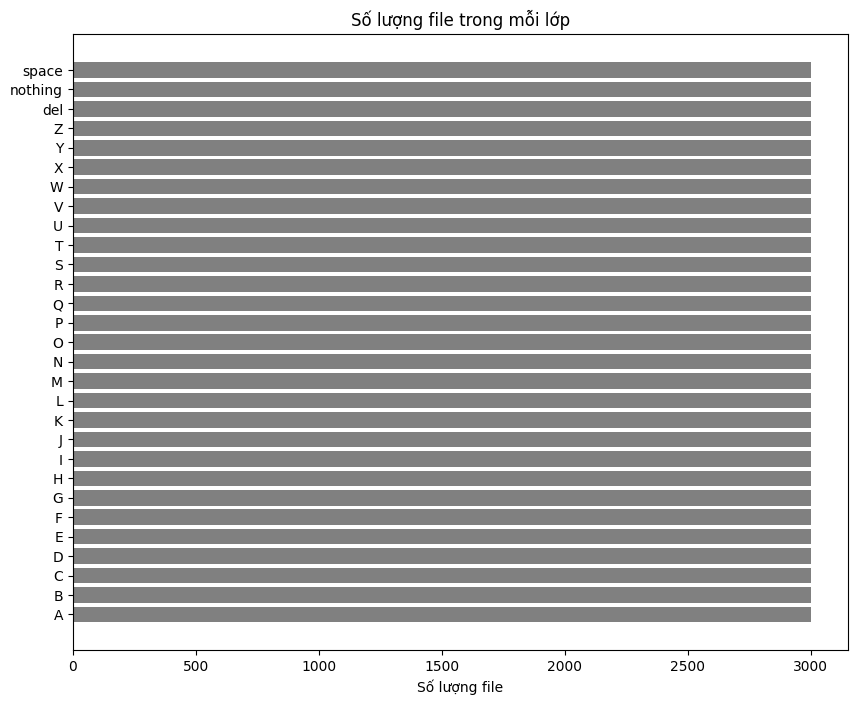

In [12]:
def count_files_per_class(base_path):
    file_counts = {}
    for cls in CLASSES:
        img_path = base_path + '/' + cls + '/**'
        path_contents = glob(img_path)
        file_counts[cls] = len(path_contents)
    return file_counts

def plot_files_per_class(file_counts):
    sorted_counts = {k: v for k, v in sorted(file_counts.items(), key=lambda item: item[1])}

    plt.figure(figsize=(10, 8))
    plt.barh(list(sorted_counts.keys()), list(sorted_counts.values()), color='gray')
    plt.xlabel('Số lượng file')
    plt.title('Số lượng file trong mỗi lớp')
    plt.show()

# Đếm số lượng file trong mỗi lớp
file_counts = count_files_per_class(TRAINING_DIR)

# Vẽ biểu đồ horizontal bar
plot_files_per_class(file_counts)

In [ ]:
list_path = []
list_labels = []
for label in CLASSES:
    label_path = os.path.join(TRAINING_DIR, label, "*")
    image_files = glob(label_path)

    sign_label = [label] * len(image_files)

    list_path.extend(image_files)
    list_labels.extend(sign_label)

metadata = pd.DataFrame({
    "image_path": list_path,
    "label": list_labels
})

metadata

,image_path,label
0,/content/drive/MyDrive/PBL6/alphabet_dataset/a...,A
1,/content/drive/MyDrive/PBL6/alphabet_dataset/a...,A
2,/content/drive/MyDrive/PBL6/alphabet_dataset/a...,A
3,/content/drive/MyDrive/PBL6/alphabet_dataset/a...,A
4,/content/drive/MyDrive/PBL6/alphabet_dataset/a...,A
...,...,...
86995,/content/drive/MyDrive/PBL6/alphabet_dataset/a...,space
86996,/content/drive/MyDrive/PBL6/alphabet_dataset/a...,space
86997,/content/drive/MyDrive/PBL6/alphabet_dataset/a...,space
86998,/content/drive/MyDrive/PBL6/alphabet_dataset/a...,space


<ipython-input-11-56f8b909ed8f>:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab20', len(file_counts))  # Sử dụng tab20 colormap với số lượng màu bằng số lớp


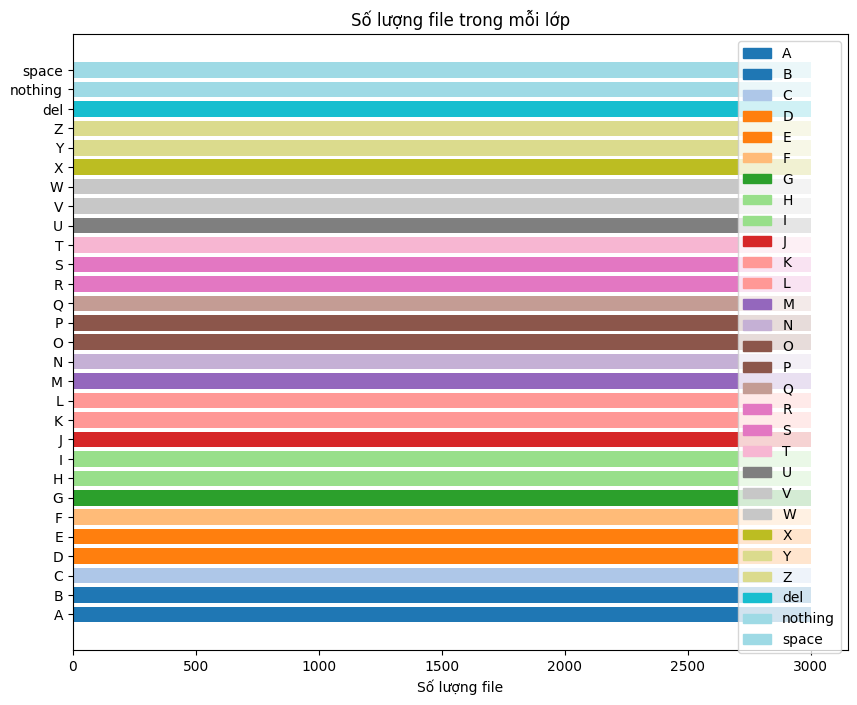

In [11]:
def count_files_per_class(base_path):
    file_counts = {}
    for cls in CLASSES:
        img_path = base_path + '/' + cls + '/**'
        path_contents = glob(img_path)
        file_counts[cls] = len(path_contents)
    return file_counts

def plot_files_per_class(file_counts):
    colors = plt.cm.get_cmap('tab20', len(file_counts))  # Sử dụng tab20 colormap với số lượng màu bằng số lớp

    sorted_counts = {k: v for k, v in sorted(file_counts.items(), key=lambda item: item[1])}

    plt.figure(figsize=(10, 8))
    bars = plt.barh(list(sorted_counts.keys()), list(sorted_counts.values()), color=colors(np.arange(len(file_counts))))
    plt.xlabel('Số lượng file')
    plt.title('Số lượng file trong mỗi lớp')

    # Thêm chú thích màu cho từng lớp
    legend_labels = [plt.Rectangle((0, 0), 1, 1, color=colors(i)) for i in range(len(file_counts))]
    plt.legend(legend_labels, list(sorted_counts.keys()), loc='upper right')

    plt.show()

# Đếm số lượng file trong mỗi lớp
file_counts = count_files_per_class(TRAINING_DIR)

# Vẽ biểu đồ horizontal bar
plot_files_per_class(file_counts)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    metadata["image_path"], metadata["label"],
    test_size=TEST_SIZE,
    random_state=2023,
    shuffle=True,
    stratify=metadata["label"]
)

data_train = pd.DataFrame({
    "image_path": X_train,
    "label": y_train
})

X_train, X_val, y_train, y_val = train_test_split(
    data_train["image_path"], data_train["label"],
    test_size=VALIDATION_SIZE/TRAIN_SIZE,
    random_state=2023,
    shuffle=True,
    stratify=data_train["label"]
)
data_train = pd.DataFrame({
    "image_path": X_train,
    "label": y_train
})
data_val = pd.DataFrame({
    "image_path": X_val,
    "label": y_val
})
data_test = pd.DataFrame({
    "image_path": X_test,
    "label": y_test
})

In [ ]:
datagen = ImageDataGenerator(rescale=1/255.,)

train_gen = ImageDataGenerator(
    rescale=1/255.,
    brightness_range=[0.8,1.2],
    zoom_range=[1.0,1.2],
    horizontal_flip=True)

train_generator = train_gen.flow_from_dataframe(
        data_train,
        directory="./",
        x_col="image_path",
        y_col="label",
        class_mode="categorical",
        batch_size=BATCH_SIZE,
        target_size=(IMAGE_SIZE, IMAGE_SIZE),
    )

validation_generator = datagen.flow_from_dataframe(
        data_val,
        directory="./",
        x_col="image_path",
        y_col="label",
        class_mode="categorical",
        batch_size=BATCH_SIZE,
        target_size=(IMAGE_SIZE, IMAGE_SIZE),
    )

test_generator = datagen.flow_from_dataframe(
        data_val,
        directory="./",
        x_col="image_path",
        y_col="label",
        class_mode="categorical",
        batch_size=1,
        target_size=(IMAGE_SIZE, IMAGE_SIZE),
        shuffle=False
)

Found 68512 validated image filenames belonging to 29 classes.
Found 9788 validated image filenames belonging to 29 classes.
Found 9788 validated image filenames belonging to 29 classes.


In [ ]:
base_model = InceptionV3(
    input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3),
    include_top = False,
    weights = 'imagenet'
)

for layer in base_model.layers:
    layer.trainable = False
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(1024, activation='relu')(x)
predictions = layers.Dense(29, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 200, 200, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 99, 99, 32)           864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 99, 99, 32)           96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 99, 99, 32)           0         ['batch_normalization[0][0

In [ ]:
train_history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=10,
    # callbacks=[callback]
)

Epoch 1/10
1071/1071 [==============================] - 1019s 942ms/step - loss: 0.4996 - accuracy: 0.8565 - val_loss: 0.3575 - val_accuracy: 0.8843
Epoch 2/10
1071/1071 [==============================] - 1013s 946ms/step - loss: 0.1820 - accuracy: 0.9387 - val_loss: 0.2514 - val_accuracy: 0.9145
Epoch 3/10
1071/1071 [==============================] - 1004s 938ms/step - loss: 0.1391 - accuracy: 0.9532 - val_loss: 0.2432 - val_accuracy: 0.9217
Epoch 4/10
1071/1071 [==============================] - 1016s 948ms/step - loss: 0.1202 - accuracy: 0.9596 - val_loss: 0.2775 - val_accuracy: 0.9133
Epoch 5/10
1071/1071 [==============================] - 989s 923ms/step - loss: 0.1018 - accuracy: 0.9658 - val_loss: 0.2256 - val_accuracy: 0.9295
Epoch 6/10
1071/1071 [==============================] - 1000s 934ms/step - loss: 0.0938 - accuracy: 0.9682 - val_loss: 0.2147 - val_accuracy: 0.9328
Epoch 7/10
1071/1071 [==============================] - 1001s 935ms/step - loss: 0.0861 - accuracy: 0.9718 

In [ ]:
import matplotlib.pyplot as plt

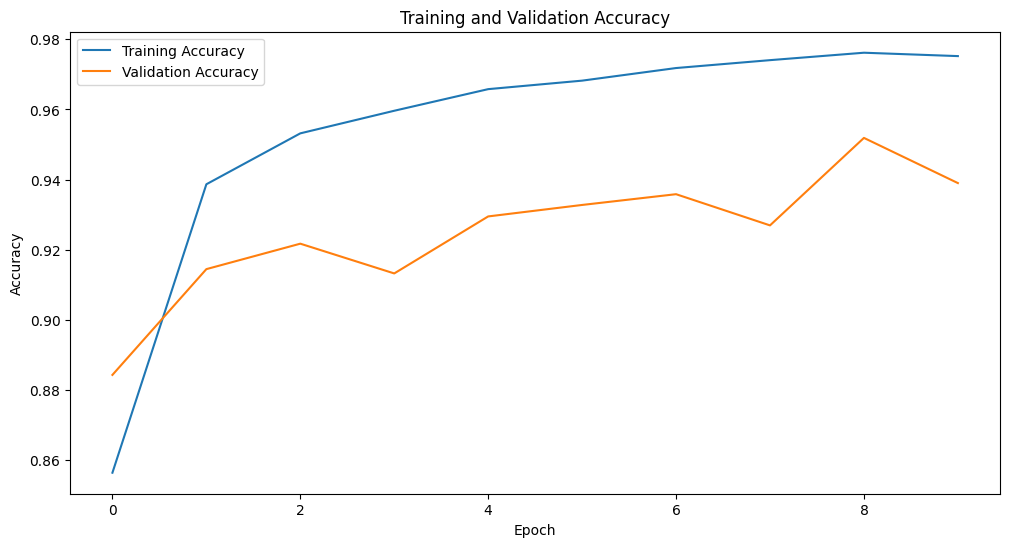

In [ ]:
plt.figure(figsize=(12, 6))

plt.plot(train_history.history['accuracy'], label='Training Accuracy')
plt.plot(train_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

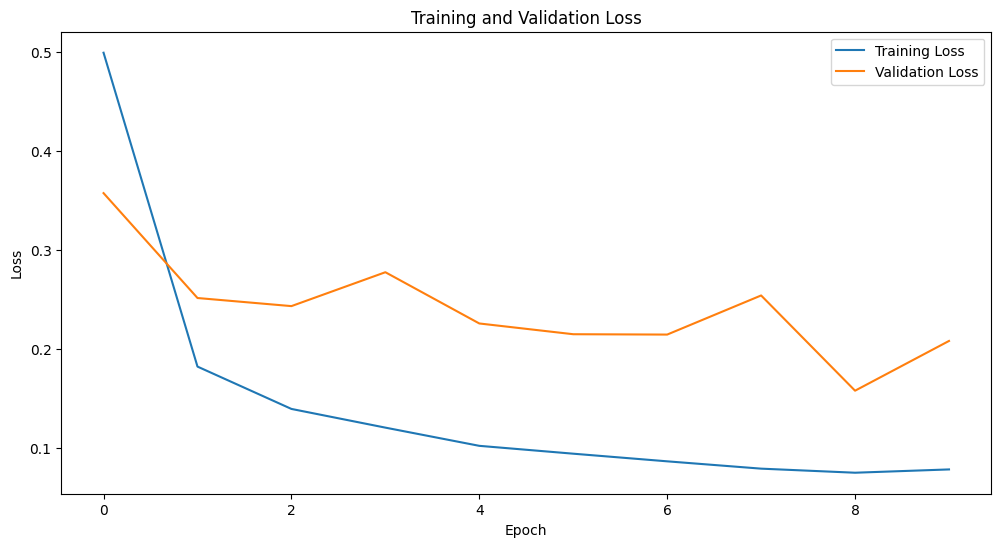

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(train_history.history['loss'], label='Training Loss')
plt.plot(train_history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

In [ ]:
for layer in model.layers[:249]:
   layer.trainable = False
for layer in model.layers[249:]:
   layer.trainable = True

model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 200, 200, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 99, 99, 32)           864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 99, 99, 32)           96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 99, 99, 32)           0         ['batch_normalization[0][0

In [ ]:
fine_tune_history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=5,
    # callbacks=[callback]
)

Epoch 1/5
1071/1071 [==============================] - 984s 918ms/step - loss: 0.0092 - accuracy: 0.9972 - val_loss: 0.0162 - val_accuracy: 0.9942
Epoch 2/5
1071/1071 [==============================] - 938s 876ms/step - loss: 0.0068 - accuracy: 0.9980 - val_loss: 0.0109 - val_accuracy: 0.9965
Epoch 3/5
1071/1071 [==============================] - 968s 904ms/step - loss: 0.0060 - accuracy: 0.9980 - val_loss: 0.0104 - val_accuracy: 0.9966
Epoch 4/5
1071/1071 [==============================] - 938s 876ms/step - loss: 0.0058 - accuracy: 0.9982 - val_loss: 0.0120 - val_accuracy: 0.9964
Epoch 5/5
1071/1071 [==============================] - 960s 896ms/step - loss: 0.0052 - accuracy: 0.9984 - val_loss: 0.0066 - val_accuracy: 0.9979


In [ ]:
model.save(MODEL_PATH)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
predictions = model.predict(test_generator)
predictions = predictions.argmax(axis=1)
true_labels = test_generator.classes

from sklearn.metrics import accuracy_score
accuracy = accuracy_score(predictions, true_labels)
print("%s: %.2f%%" % ("Evaluate Test Accuracy", accuracy))

9788/9788 [==============================] - 133s 13ms/step
Evaluate Test Accuracy: 1.00%


In [ ]:
def visualize_train_val(history):
  # Visualize Training and Validation Results
  fig = make_subplots(
          rows=1, cols=2,
          subplot_titles=["Model Loss", "Model Accuracy"],
  )

  # Configuration Plot
  class PlotCFG:
      marker_size = 8
      line_size = 2
      train_color = "#76503d"
      valid_color = "#deb392"


  # Loss Plot
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  fig.add_trace(
      go.Scatter(
          x=np.arange(1, len(loss)+1), y=loss,
          mode="markers+lines",
          marker=dict(
              color=PlotCFG.train_color, size=PlotCFG.marker_size,
              line=dict(color="White", width=0.5)
          ),
          line=dict(color=PlotCFG.train_color, width=PlotCFG.line_size),
          name="Training Loss"
      ), row=1, col=1
  )

  fig.add_trace(
      go.Scatter(
          x=np.arange(1, len(val_loss)+1), y=val_loss,
          mode="markers+lines",
          marker=dict(
              color=PlotCFG.valid_color, size=PlotCFG.marker_size,
              line=dict(color="White", width=0.5)
          ),
          line=dict(color=PlotCFG.valid_color, width=PlotCFG.line_size),
          name="Validation Loss"
      ), row=1, col=1
  )



  # Accuracy Plot
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  fig.add_trace(
      go.Scatter(
          x=np.arange(1, len(acc)+1), y=acc,
          mode="markers+lines",
          marker=dict(
              color=PlotCFG.train_color, size=PlotCFG.marker_size,
              line=dict(color="White", width=0.5)
          ),
          line=dict(color=PlotCFG.train_color, width=PlotCFG.line_size),
          name="Training Accuracy"
      ), row=1, col=2
  )
  fig.add_trace(
      go.Scatter(
          x=np.arange(1, len(val_acc)+1), y=val_acc,
          mode="markers+lines",
          marker=dict(
              color=PlotCFG.valid_color, size=PlotCFG.marker_size,
              line=dict(color="White", width=0.5)
          ),
          line=dict(color=PlotCFG.valid_color, width=PlotCFG.line_size),
          name="Validation Accuracy"
      ), row=1, col=2
  )

  # Update Axes
  fig.update_xaxes(title="Epochs", linecolor="Black", ticks="outside", row=1, col=1)
  fig.update_xaxes(title="Epochs", linecolor="Black", ticks="outside", row=1, col=2)
  fig.update_yaxes(title="Categorical Loss", linecolor="Black", ticks="outside", row=1, col=1)
  fig.update_yaxes(title="Accuracy", linecolor="Black", ticks="outside", row=1, col=2)


  # Update Layout
  fig.update_layout(
      title="Training Loss and Metrics", title_x=0.5,
      width=950, height=400,
      showlegend=False,
      plot_bgcolor="White",
      paper_bgcolor="White"
  )

  # Show
  fig.show(iframe_connected=True)

In [ ]:
visualize_train_val(train_history)

In [ ]:
visualize_train_val(fine_tune_history)

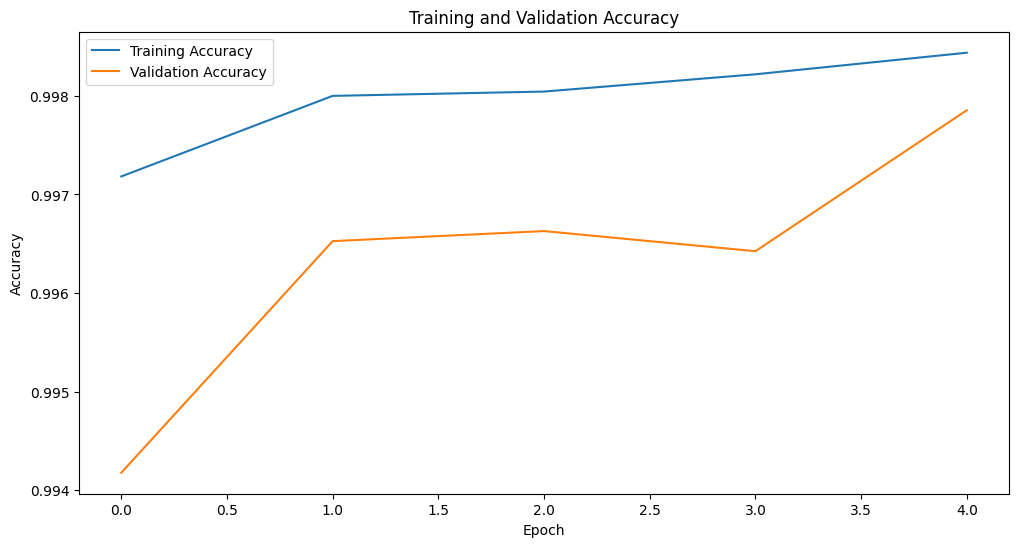

In [ ]:
plt.figure(figsize=(12, 6))

plt.plot(fine_tune_history.history['accuracy'], label='Training Accuracy')
plt.plot(fine_tune_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

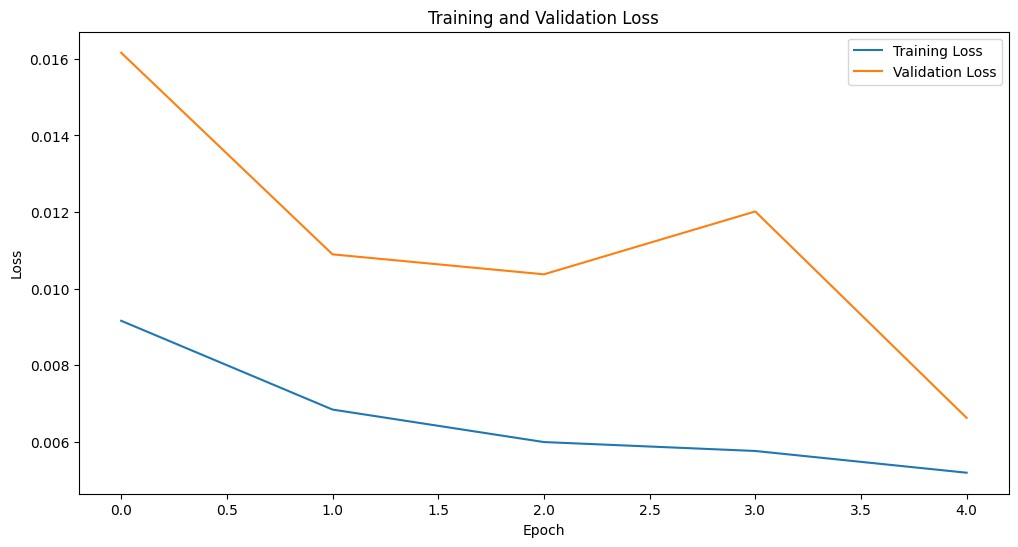

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(fine_tune_history.history['loss'], label='Training Loss')
plt.plot(fine_tune_history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

In [ ]:
confusion_matrix = tf.math.confusion_matrix(
        labels=true_labels,
        predictions=predictions,
        num_classes=29)

In [ ]:
# Create Figure
fig = go.Figure()

# Heatmap
fig.add_trace(
    go.Heatmap(
        z=confusion_matrix,
        x=CLASSES,
        y=CLASSES,
        text=confusion_matrix,
        texttemplate="<b>%{text}</b>",
        textfont={"size":8},
        colorscale=[[0, '#f4f4f4'],[1.0, '#76503d']],
        showscale = False,
        ygap = 5,
        xgap = 5,
        hovertemplate=
        '''
        Actual: %{y}<br>
        Predicted: %{x}<br>
        Total: %{text}
        ''',
        name="Confusion Matrix"
    )
)

# Update Axes
fig.update_xaxes(title="<b>Predicted Values</b>", tickfont_size=10)
fig.update_yaxes(title="<b>Actual Values</b>", tickfont_size=10)

# Update Layout
fig.update_layout(title_text='Confusion Matrix', title_x=0.5, font_size=14,
                  width=1050,
                  height=1115,
                  plot_bgcolor='white',
                  showlegend=False,
)

# Show
fig.show()

In [21]:
model = load_model('/content/drive/MyDrive/PBL6/model_trained/cnn_asl_model.h5')

1/1 [==============================] - 0s 140ms/step
M


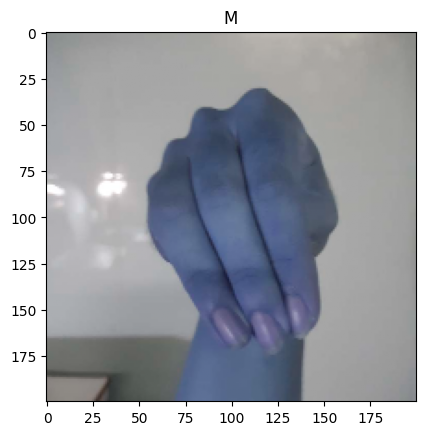

In [31]:
image_location = '/content/drive/MyDrive/PBL6/alphabet_dataset/m.jpg'

# Creating list of available classes stored in classes.txt.
classes_file = open("/content/drive/MyDrive/PBL6/source_code/classes.txt")
classes_string = classes_file.readline()
classes = classes_string.split()
classes.sort()  # The predict function sends out output in sorted order.

IMAGE_SIZE = 200

img = cv2.imread(image_location)
img = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE))
img = np.array(img) / 255.
plt.imshow(img)
img = img.reshape((1, IMAGE_SIZE, IMAGE_SIZE, 3))

prediction = np.array(model.predict(img))
predicted = classes[prediction.argmax()]
plt.title(predicted)


print(predicted)

In [34]:
test_folder = '/content/drive/MyDrive/PBL6/alphabet_dataset/test_real'

1/1 [==============================] - 0s 99ms/step


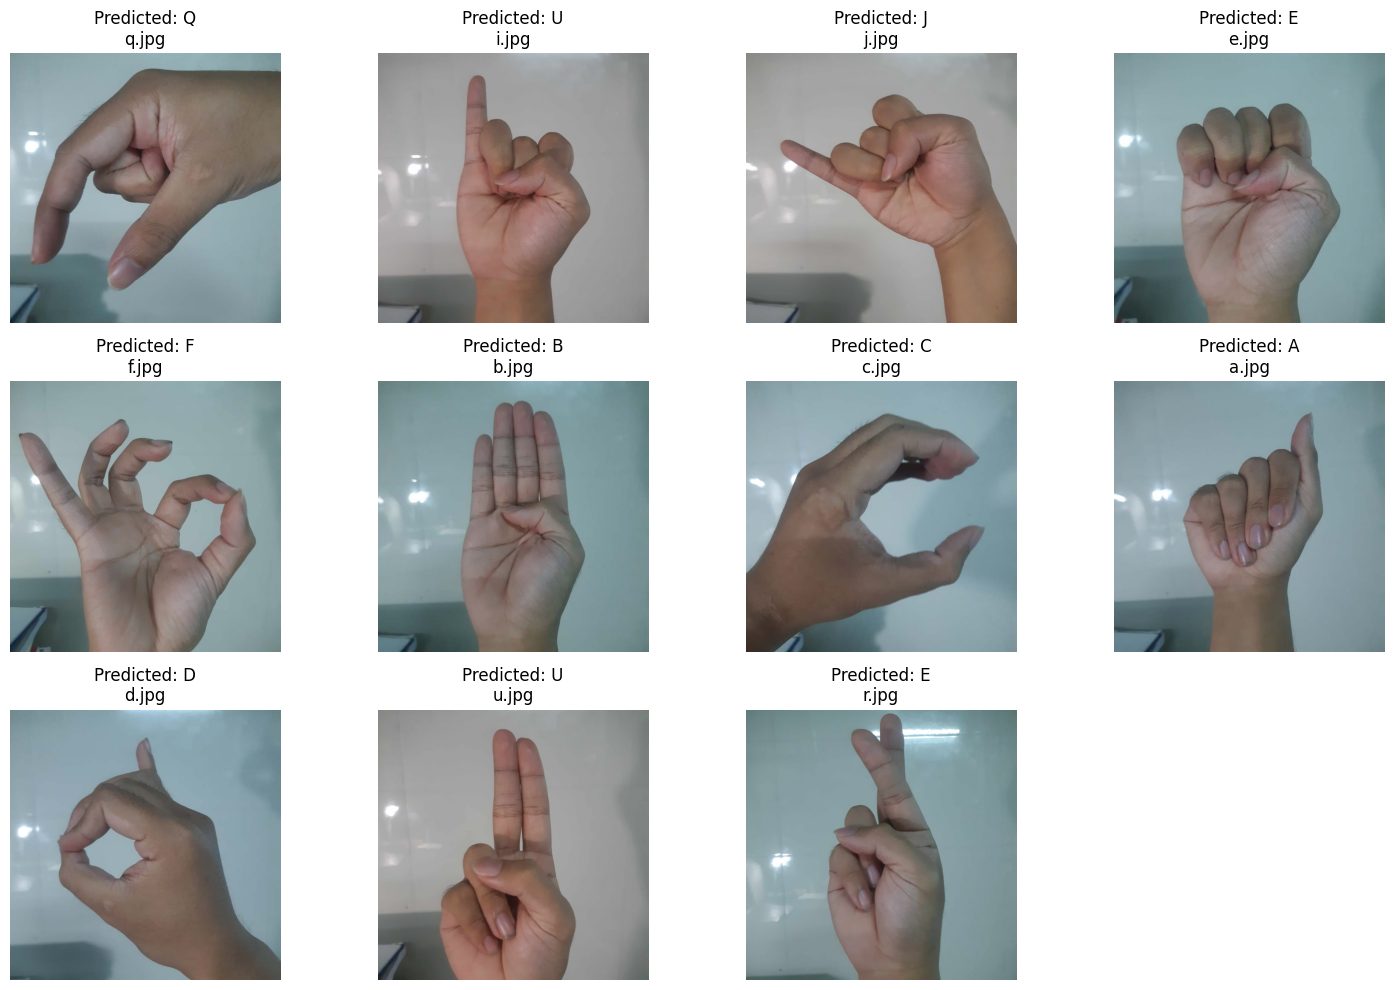

In [35]:
plt.figure(figsize=(15, 10))

# Duyệt qua các file trong thư mục test và thực hiện dự đoán
for i, filename in enumerate(os.listdir(test_folder)):
    if filename.endswith(".jpg"):
        image_location = os.path.join(test_folder, filename)

        # Đọc và xử lý ảnh
        img = cv2.imread(image_location)
        img = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE))
        img = np.array(img) / 255.
        img = img.reshape((1, IMAGE_SIZE, IMAGE_SIZE, 3))

        # Dự đoán
        prediction = np.array(model.predict(img))
        predicted = classes[prediction.argmax()]

        # Hiển thị ảnh và kết quả dự đoán trong subplot
        plt.subplot(3, 4, i + 1)
        plt.imshow(cv2.cvtColor(cv2.imread(image_location), cv2.COLOR_BGR2RGB))
        plt.title(f"Predicted: {predicted}\n{filename}")
        plt.axis('off')

plt.tight_layout()
plt.show()